# Audio Transcription Tool
## Attempt to Automatically Transcribe Audio Files Using ML

# Instructions
1. **Place all files in the 'INPUTS' folder**
1. Click Run > Run all cells.
1. Retrieve results from 'OUTPUTS' folder.

<font color='red' size='3'>Optional:</font>
Choose a model for transcription below!

There are several models available to perform the transcription and translation tasks for each audio file. In the following cell, choose the desired model to be used for all tasks. 

**NOTE:**
_The smallest models (tiny, base) are the fastest but less accurate, and the larger models (medium, large) are slower but more accurate._

# Model Selection

In [1]:
import ipywidgets as widgets
# Model Selection Widget
w = widgets.ToggleButtons(
    options=['Tiny', 'Base', 'Small', 'Medium', 'Large'],
    description='Please select a model size: ',
    disabled=False,
    button_style='info',
    value='Medium' # Medium model is default, quite slow but far more accurate than base.
)
w

ToggleButtons(button_style='info', description='Please select a model size: ', index=3, options=('Tiny', 'Base…

# Tool Setup

In [2]:
## Library Imports
import os
import pydub
import pathlib
import pickle
import whisper
import warnings
import numpy as np
from platform import python_version
from datetime import datetime
from pathlib import Path

## Helper Vars
CWD = pathlib.Path.cwd()
INPUT = CWD / 'INPUTS'
OUT = CWD / 'OUTPUT'
TEMP = CWD / '.transient'

## Setup Directory
Path.mkdir(OUT, exist_ok=True)
Path.mkdir(TEMP, exist_ok=True)

## Ensure compatible torch version (as of 2022-11-12)
assert python_version().split('.')[0] == '3'
assert int(python_version().split('.')[1]) <= 10

# Import

In [3]:
# Load Files
AcceptableFileTypes = {'.m4a', '.flac', '.mp3'}
AcceptableFileTypes = [x.lower() for x in AcceptableFileTypes]

files = {}
print(f'Importing audio files from: \n  - {INPUT}\n')
for f in pathlib.Path.iterdir(INPUT):
    name = f.name
    ext = f.suffix
    
    if ext.lower() in AcceptableFileTypes:
        print(f"  -> {name[:-1*len(ext)]}")
        files[name[:-1*len(ext)]] = f

Importing audio files from: 
  - /Users/alberto/Desktop/Audio_V2/INPUTS

  -> Tonle Sap Interview Two
  -> Jean Informal Conversation
  -> New Recording
  -> test
  -> Barbra
  -> Kate Miller Interview
  -> Tonle Sap Interview One
  -> test copy


# Convert All to FLAC
Convert all the imported audio files to FLAC files in order to be used as input for the transcription model.

<font size='2'>https://github.com/jiaaro/pydub/blob/master/API.markdown</font>

## Whole File Export

In [4]:
# Make temp FLAC file Dir
FLAC_PATH = TEMP / "flac_files"
Path.mkdir(FLAC_PATH, exist_ok=True)
flacPaths = {}

# Force Rewrite
rewriteFlag = False

# Convert to FLAC #
for name, path in files.items():
    
    # Export name
    expName = FLAC_PATH / f"{name}.flac"
    flacPaths[name] = expName

    # Check if the converted file already exists
    if (not Path.is_file(expName)) | rewriteFlag:
        print(f"  -> Converting: {name}")

        # Load Original Audio
        f = path
        soundOG = pydub.AudioSegment.from_file(f)

        # Convert
        file_handle = soundOG.export(expName, format="flac")
    else:
        print(f"- Converted Earlier: {name}")

- Converted Earlier: Tonle Sap Interview Two
- Converted Earlier: Jean Informal Conversation
- Converted Earlier: New Recording
- Converted Earlier: test
- Converted Earlier: Barbra
- Converted Earlier: Kate Miller Interview
- Converted Earlier: Tonle Sap Interview One
- Converted Earlier: test copy


# Transcribe via OpenAI/Whisper

<!-- 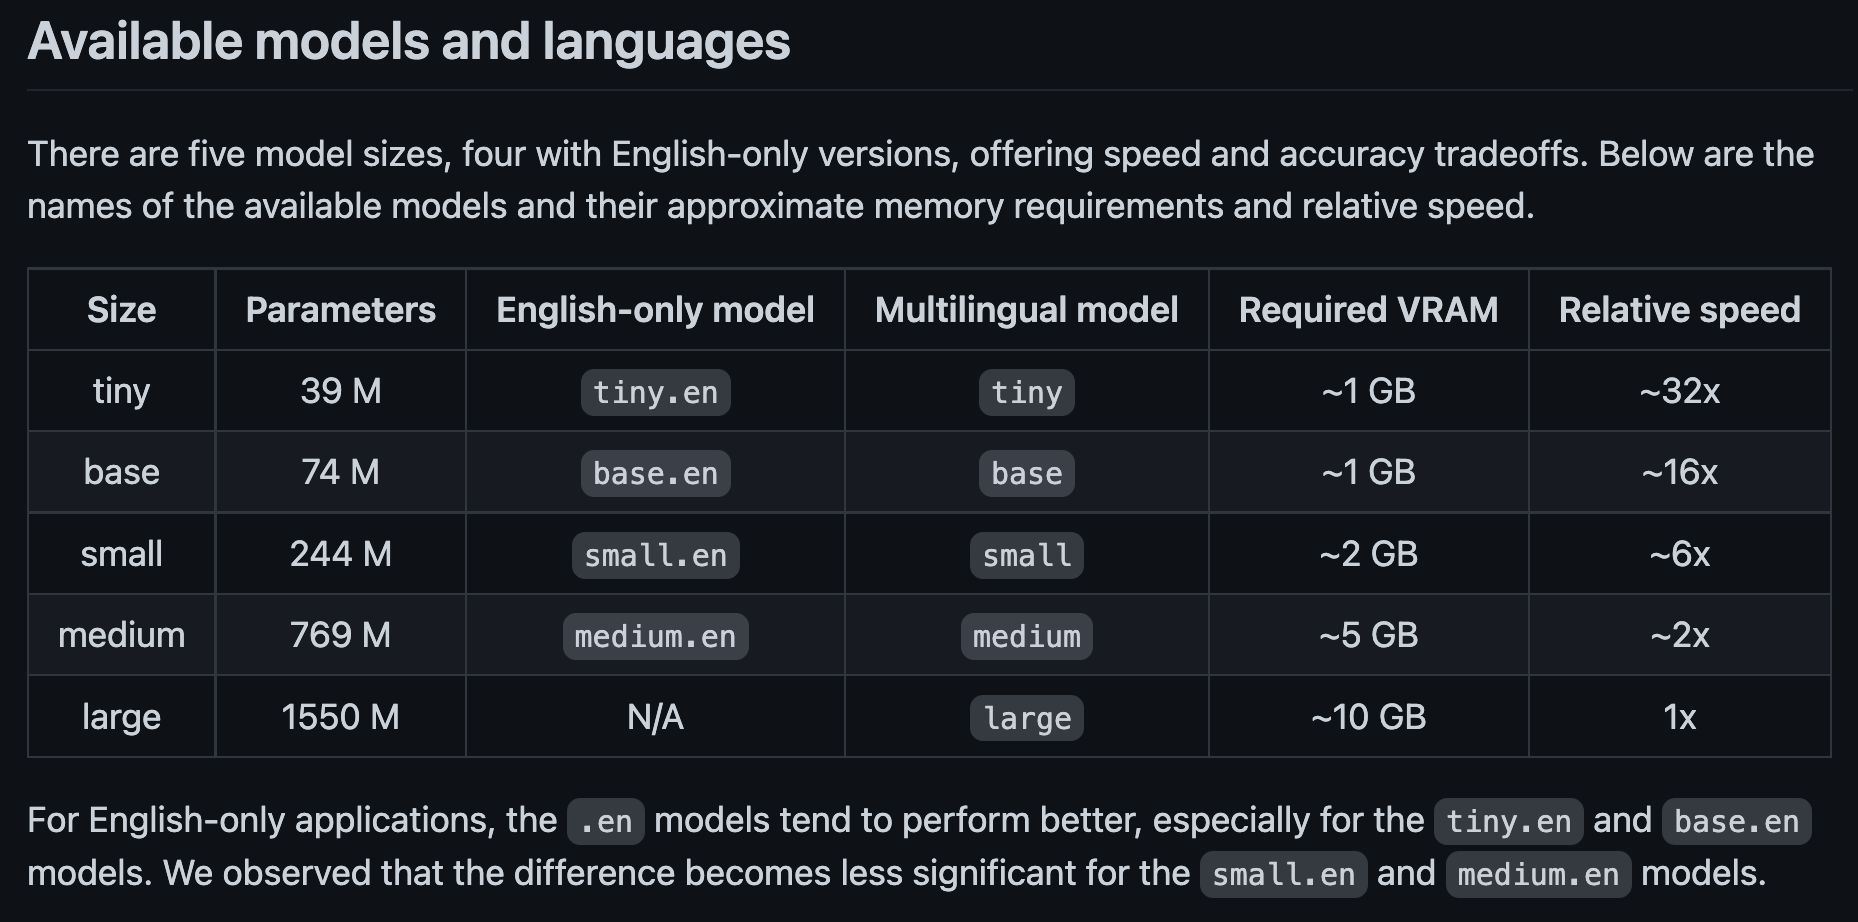 -->
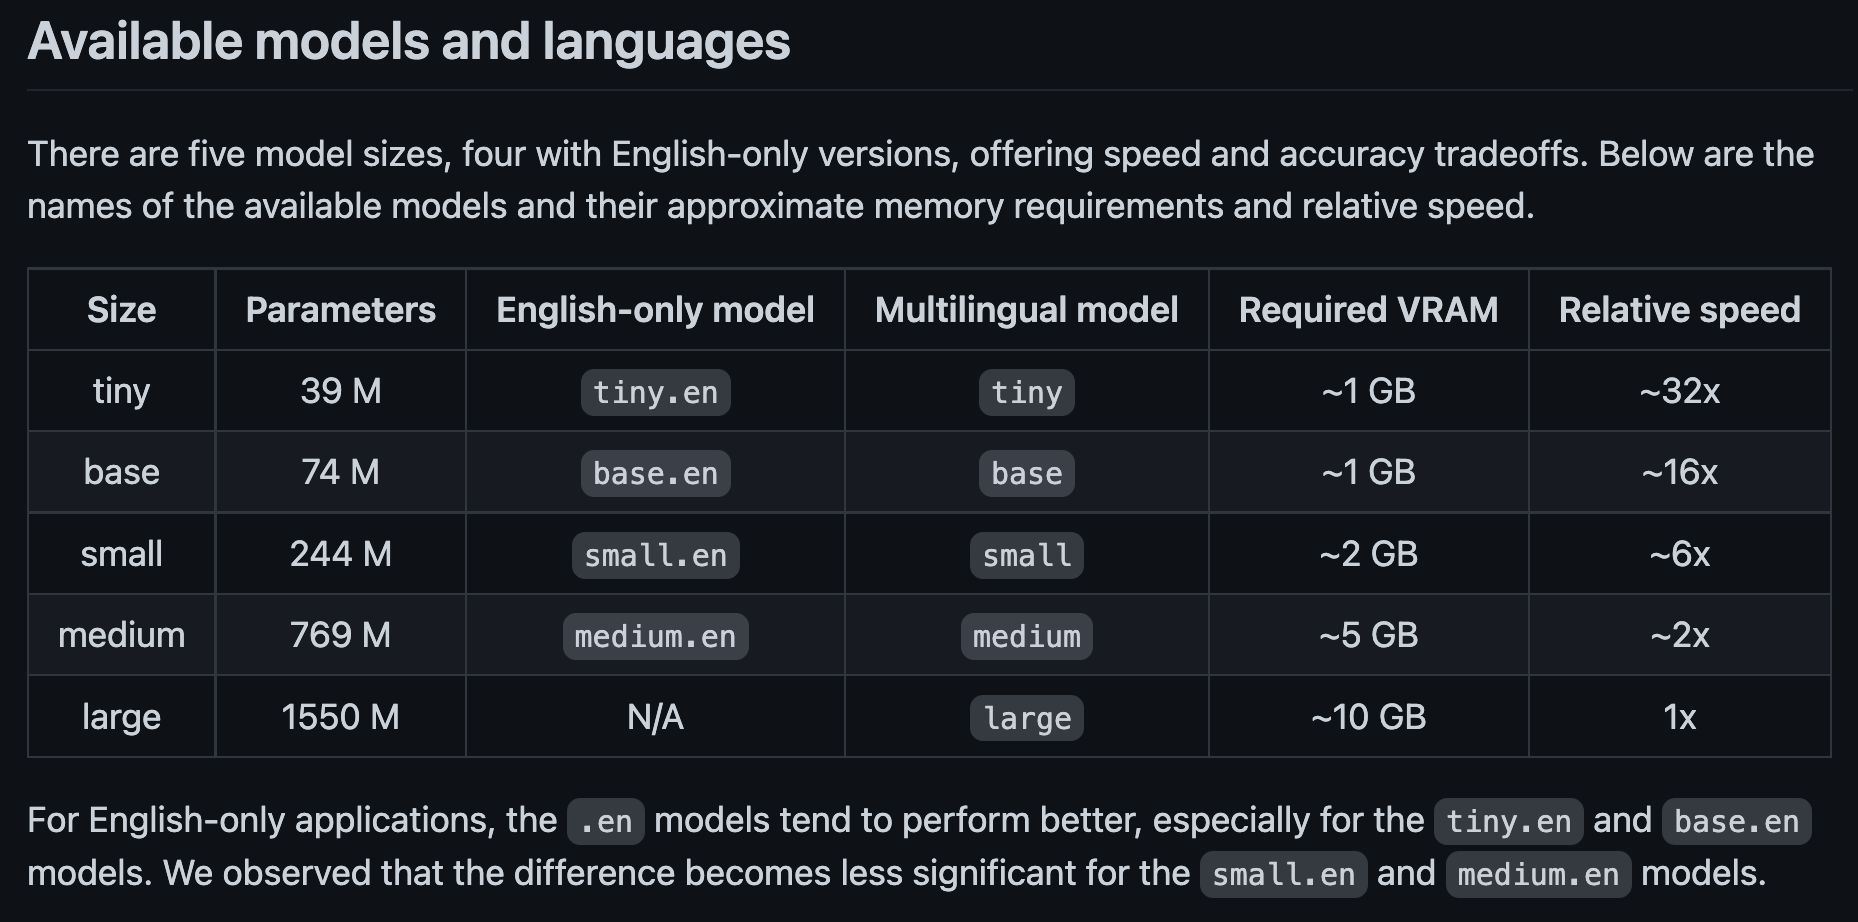
    
See: https://github.com/openai/whisper

In [5]:
# PARAMETERS for transcription
MODEL_SIZE = w.value.lower()
FORCE_TRANSCRIBE = False

# Load model
model = whisper.load_model(MODEL_SIZE)

# Save results
WHISPER_OUT = OUT / f"Whisper_{MODEL_SIZE}"
Path.mkdir(WHISPER_OUT, exist_ok=True)

In [6]:
print(f"Transcribing via OpenAI/Whisper: {MODEL_SIZE}!")

for name, path in flacPaths.items():
    # print(name, path)
    expName = OUT / WHISPER_OUT / f"{name}.txt"
    
    # Skip this interview if file has been transcribed before
    if Path.is_file(expName) & (not FORCE_TRANSCRIBE):
        print(f" - Transcribed Earlier: {name}")
        continue
        
    # Transcribe #
    print(f"  -> Transcribing: {name}")
    tic = datetime.now()
    
    
    # load audetect_language and pad/trim it to fit 30 second sliding window
    audio = whisper.load_audio(path)
    audio = whisper.pad_or_trim(audio)

    # make log-Mel spectrogram and move to the same device as the model
    mel = whisper.log_mel_spectrogram(audio).to(model.device)
    
    # detect the spoken language
    _, probs = model.detect_language(mel)
    lang = max(probs, key=probs.get)
    # print(f"Detected language: {lang}")  
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore") # Ignore FP16 not being available on device
        
        # Detect multiple languages
        possibleNumberOfLanguages = sum([x > .05 for x in probs.values()])
        multilingual = True if possibleNumberOfLanguages >= 2 else False
        
        # decode the audio
        if multilingual:
            
            # Translates non-english to english and transcribes original as best possible
            result_translate = model.transcribe(str(path), task="translate")
            result = model.transcribe(str(path))
            
            # Save ORIGINAL results
            with open(expName, 'w') as f:
                f.write(result["text"])
                
            # Save TRANSLATED results
            with open(OUT / WHISPER_OUT / f"{expName.name[:-4] + ' - translated'}.txt", 'w') as f:
                f.write(result_translate["text"])
                
        else:
            
            result = model.transcribe(str(path))
            
            # Save results
            with open(expName, 'w') as f:
                f.write(result["text"])
    
    toc = datetime.now()
    print(f"      - Done!, Elapsed Time: {str(toc-tic)[:-7]}")

Transcribing via OpenAI/Whisper: medium!
 - Transcribed Earlier: Tonle Sap Interview Two
 - Transcribed Earlier: Jean Informal Conversation
 - Transcribed Earlier: New Recording
 - Transcribed Earlier: test
 - Transcribed Earlier: Barbra
 - Transcribed Earlier: Kate Miller Interview
 - Transcribed Earlier: Tonle Sap Interview One
 - Transcribed Earlier: test copy
